# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [53]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline

### get grid info

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [3]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood', zorder=3)
    return(pc)

In [101]:
def saltCS(section, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    salts = mydata.final_salt[(mydata.final_section==section)]
    
    vmax = 32
    vmin = 29

    H = binned_statistic_2d(dist, depths, salts, statistic=np.mean, bins=[np.array(t_dist[lonW:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW:lonE]), t_depths])

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H.statistic.T, vmin = vmin, vmax = vmax, cmap=cm.matter)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_label('psu', labelpad=-20)
    cb1.set_ticks([vmin, vmax])
    
    pc = draw_patches(fmask, lonW, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

In [135]:
def DsaltCS(section, latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lat = mymesh.gphit[0,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, igrid, latS:latN].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lats/m2lat
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    salts = mydata.final_salt[(mydata.final_section==section)]
    
    vmax = 32
    vmin = 29

    H = binned_statistic_2d(dist, depths, salts, statistic=np.mean, bins=[np.array(t_dist[latS:latN+1]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[latS:latN+1]), t_depths])

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H.statistic.T, vmin = vmin, vmax = vmax, cmap=cm.matter)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_label('psu', labelpad=-20)
    cb1.set_ticks([vmin, vmax])
    
#     pc = draw_patches(fmask, latS, latN, np.array(t_dist), np.array(t_depths))
#     ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS+1], t_dist[latN-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS+1], t_lat[latN-1], 5),2))
    ax.set_xlim((t_dist[latS], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

In [113]:
#lets make a fun lil matrix with all of the info we need about every channel to run the cross-section code
#in the format [section, jgridW, jgridE, figrid, maxdepth]
admiralty = [2, 255, 267, 204, 100]
rosario = [4, 286, 307, 266, 100]
sanjuan = [5, 264, 266, 280, 100]
haro = [6, 218, 242, 304, 300]
straits = [admiralty, rosario, sanjuan, haro]
names = ['Admiralty', 'Rosario', 'San Juan', 'Haro']

#in the format [section, jgridS, jgridN, figrid, maxdepth]
decep = [3, 246, 247, 309, 100]

# March
## Backwards run (source water, going from strait in title to the JDF)

In [103]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_31mar19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15mar19/SalishSea_1d_20190315_20190315_grid_T.nc'
mydata = xr.open_dataset(file)

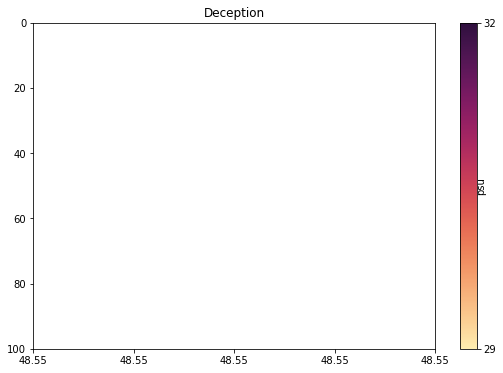

In [136]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6))
DsaltCS(decep[0], decep[1], decep[2], decep[3], decep[4], axs, "Deception")

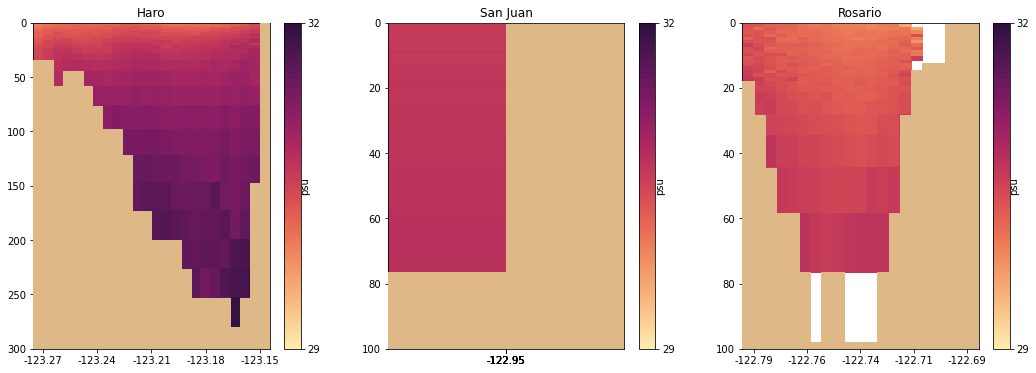

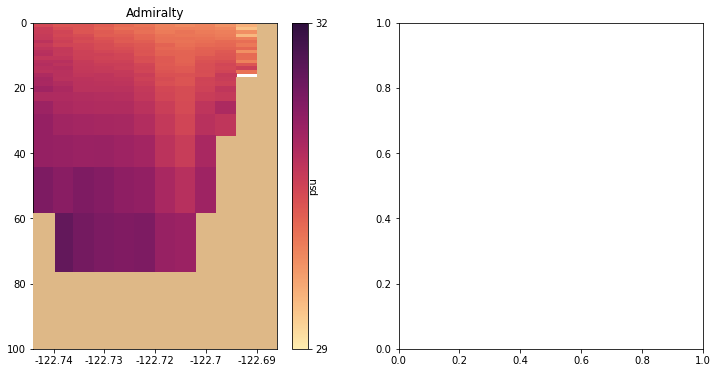

In [124]:
fig1, axs = plt.subplots(1, 3, figsize=(18, 6))
saltCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
saltCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
saltCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

fig2, axs = plt.subplots(1, 2, figsize=(12, 6))
saltCS(admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[0], "Admiralty")

## Forwards run (from JDF to these straits)

In [6]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01mar19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15mar19/SalishSea_1d_20190315_20190315_grid_T.nc'
mydata = xr.open_dataset(file)

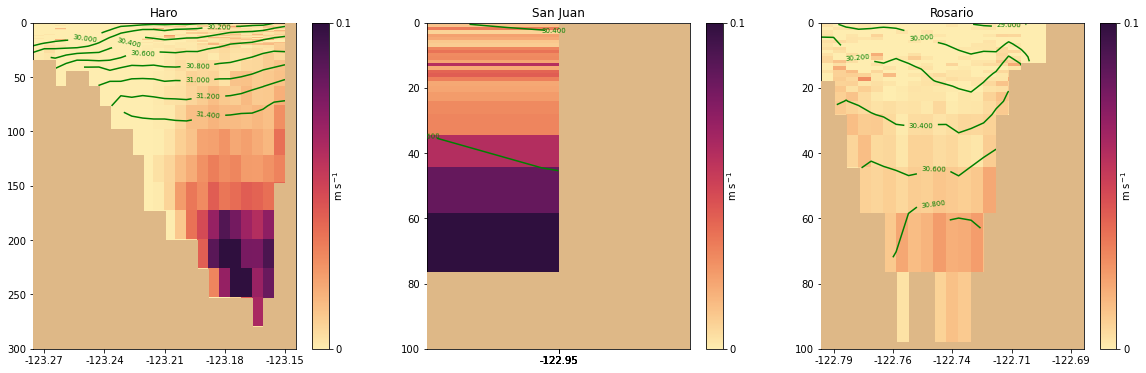

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

# June
## Backwards run (source water, going from strait in title to the JDF)

In [15]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_01jul19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15jun19/SalishSea_1d_20190615_20190615_grid_T.nc'
mydata = xr.open_dataset(file)

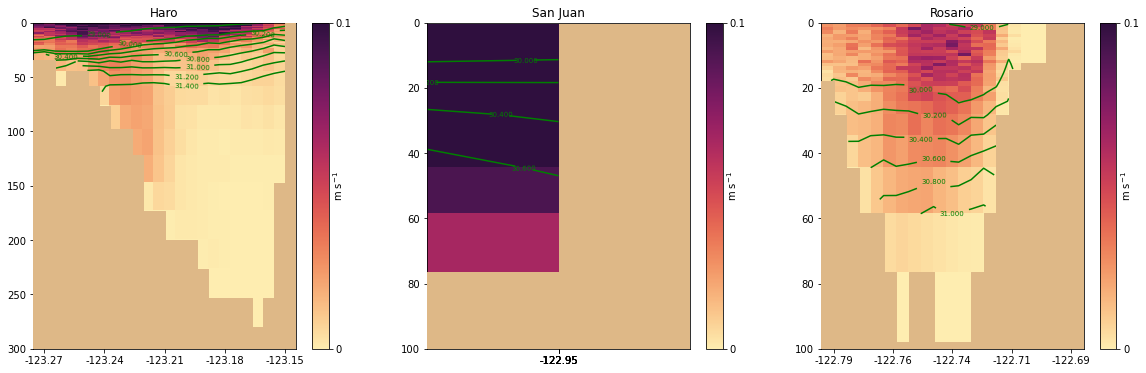

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

## Forwards run (from JDF to these straits)

In [17]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01jun19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15jun19/SalishSea_1d_20190615_20190615_grid_T.nc'
mydata = xr.open_dataset(file)

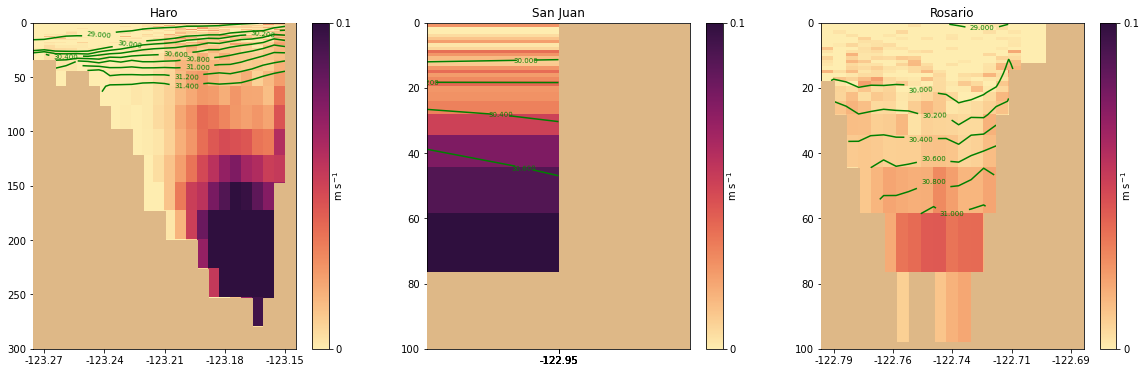

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

# September
## Backwards run (source water, going from strait in title to the JDF)

In [19]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_01oct19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15sep19/SalishSea_1d_20190915_20190915_grid_T.nc'
mydata = xr.open_dataset(file)

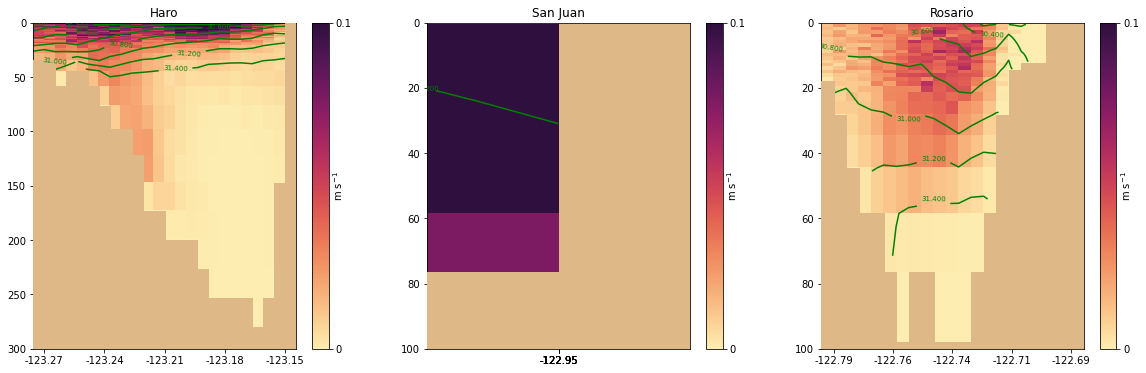

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

## Forwards run (from JDF to these straits)

In [21]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01sep19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15sep19/SalishSea_1d_20190915_20190915_grid_T.nc'
mydata = xr.open_dataset(file)

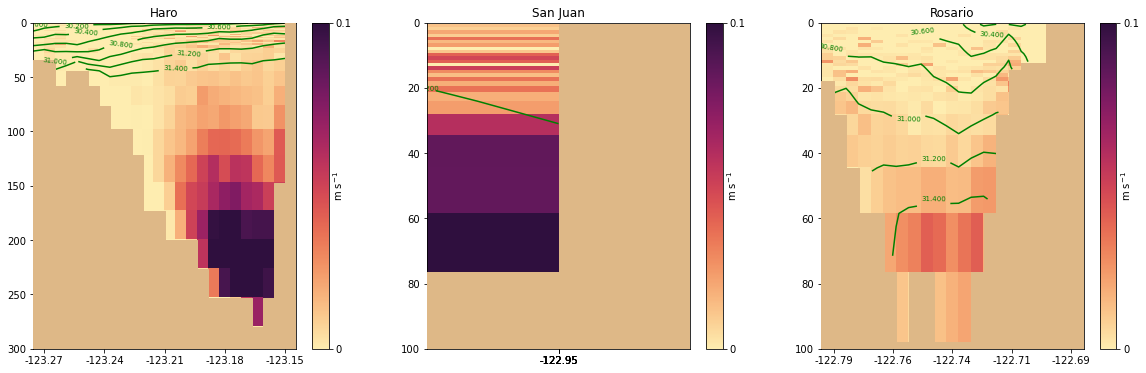

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

# December
## Backwards run (source water, going from strait in title to the JDF)

In [23]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_31dec19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
mydata = xr.open_dataset(file)

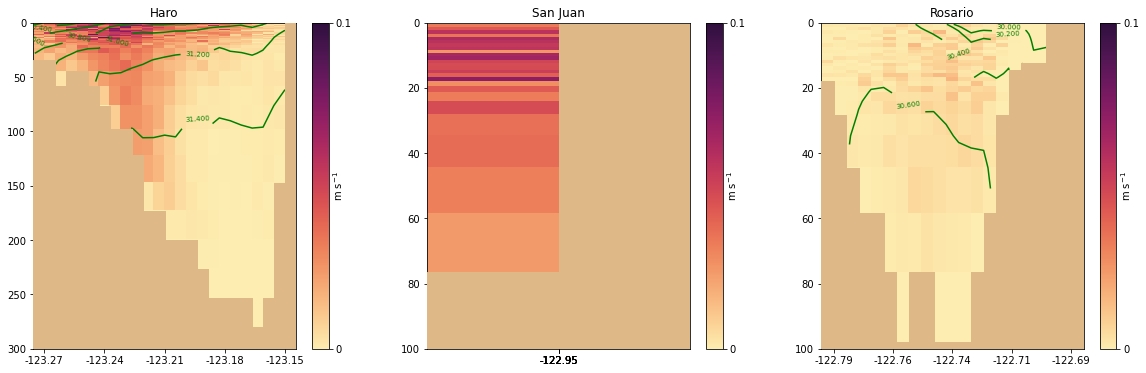

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

## Forwards run (from JDF to these straits)

In [25]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01dec19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
mydata = xr.open_dataset(file)

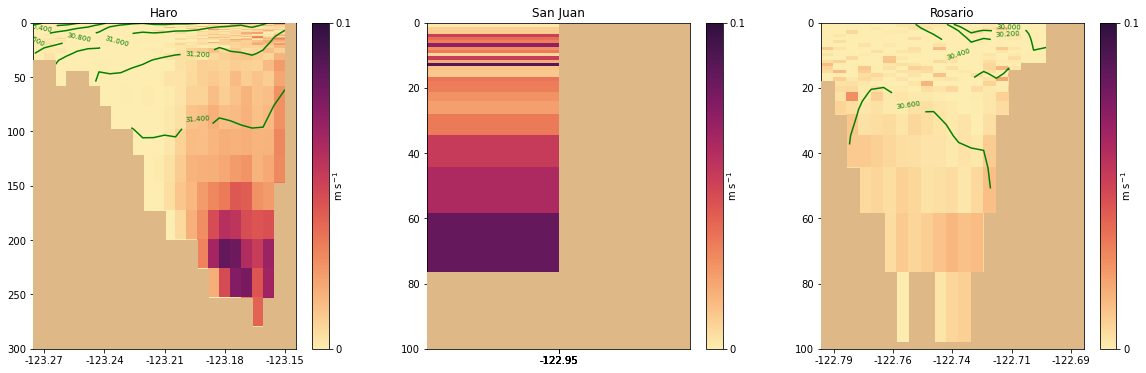

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

# One year 
### Forward

In [27]:
# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward1yr_01jan19/ariane_positions_quantitative.nc'
# salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
# mydata = xr.open_dataset(file)
# time1 = mydata.init_t[0]

In [28]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
# tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
# tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

### Backward

In [29]:
# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward1yr_31dec19/ariane_positions_quantitative.nc'
# salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
# mydata = xr.open_dataset(file)
# time1 = mydata.init_t[0]

In [30]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
# tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
# tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")